In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy
import sklearn as sk

# Downloading data

In [2]:
#fetch data
import os, tarfile
from six.moves import urllib
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = "datasets/housing"
LOCAL_HOUSING_PATH = "./" #curent directory
HOUSING_URL = DOWNLOAD_ROOT + HOUSING_PATH + "/housing.tgz"


#Function to retrieve dataset
def fetch_housing_data(housing_url=HOUSING_URL, housing_path=LOCAL_HOUSING_PATH): 
    if os.path.isfile(os.path.join(housing_path, "housing.csv")):
        return
    if not os.path.isdir(housing_path):
             os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [3]:
#Load csv file into pandas dataframe
def load_housing_data(housing_path=LOCAL_HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [4]:
#The function will download data only if housing.csv is not found 
fetch_housing_data()
housing = load_housing_data()

# Looking at data

methods used:
- df.head(): shows first rows
- df.info(): number of rows, valid field per column, data type
- df['field'].value_counts(): get distinct values
- df.describe(): statistics of numerical attributes (null values are ignored)
- housing.hist(bins=20, figsize=(20,15)) to plot the histogram of each numerical value: the bins are the 'groups' of the histogram.

## Each row is a district with 10 attributes

In [5]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


## Columns datatypes, total num of rows and number of non-null vals

In [6]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


- #### total_bedrooms has only 20433 valid values out of 20640
- #### All attributes are numerical expect ocean proximity: it can be any type of object but since it has been loaded from a csv, we know it's a string.
- #### Looking at housing.head(), you'll see first 5 rows of ocean_proximity have the same value: maybe it is a categorical value: let's check it:

In [7]:
#get values type of categorical field
housing['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

#### ocean_proximity is a categorical variable with 5 values: '1H OCEAN' (9136 rows), 'INLAND' (6551 rows), 'NEAR OCEAN' (2658 rows), 'NEAR BAY' (2290 rows), 'ISLAND' (5 rows)

## Other numerical variable statistics

In [8]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


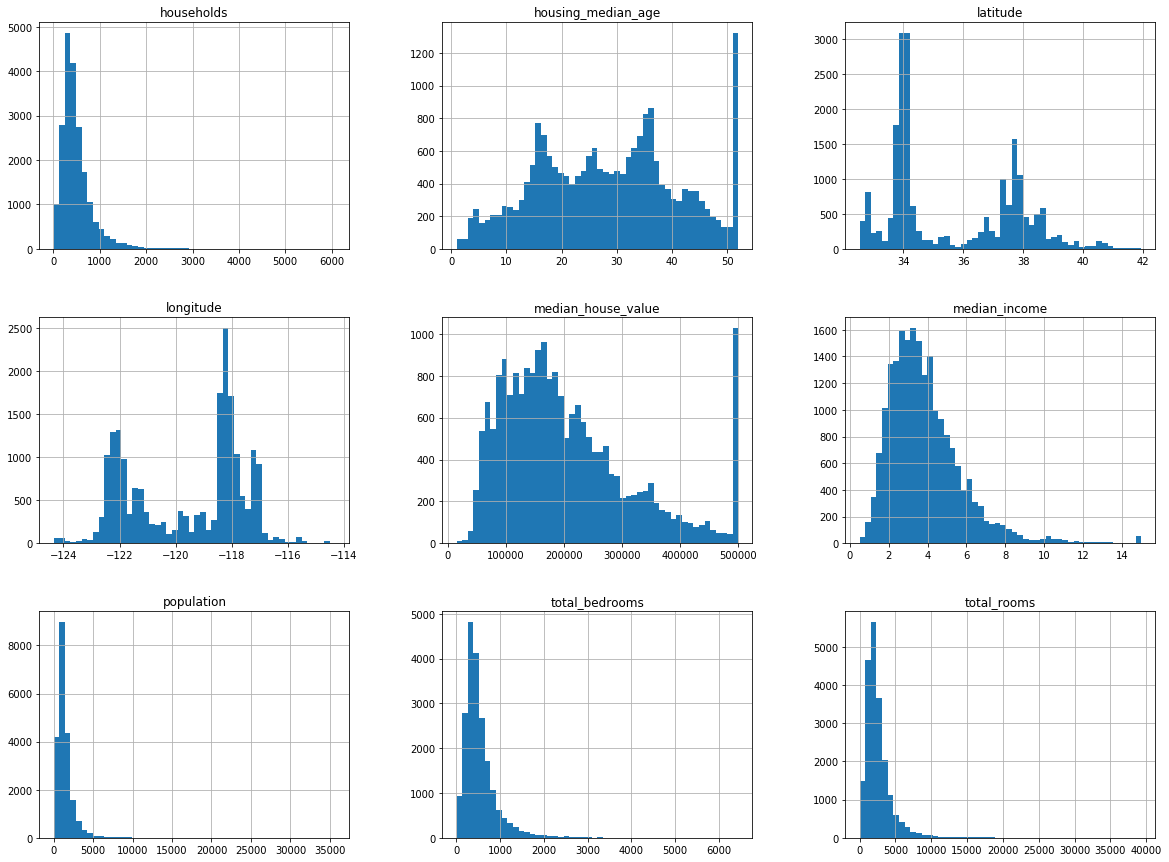

In [9]:
%matplotlib inline 
import matplotlib.pyplot as plt 
housing.hist(bins=50, figsize=(20,15)) 
plt.show()


### Inferences from the histo
- the incomes are not in USD but have been scaled and cupped to 15.0001 for higher median incomes and to 0.4999 for lower median incomes
- the housing median age and the median house value were also capped: this latter might be a problem since it is the value we want to predict.
- Values have very different scales
- many histograms are tail heavy: they extend much farther to the right of the median than to the left. This may make it a bit harder for some Machine Learning algorithms to detect patterns. We will try transforming these attributes later on to have more bell-shaped distributions.


# Create a test set
Running the function `split_train_test` multiple times will generate a different test set!
One solution is to save the data-set and load it next times. Another solution is to use random generator seeds so that the pseudo-random sequence starts every-time from the same point. But these solutions will break next time one fetches an updated dataset.

## Solution
A common solution is to use each instance’s identifier to decide whether or not it should go in the test set (assuming instances have a unique and immutable identifier). For example, you could compute a hash of each instance’s identifier, keep only the last byte of the hash, and put the instance in the test set if this value is lower or equal to 51 (~20% of 256). This ensures that the test set will remain consistent across multiple runs, even if you refresh the dataset. It is assuming a uniform distribution by hash algorithm
Look at the function `split_train_test_by_id` and `test_set_check`.

### Further problem
Unfortunately, the housing dataset does not have an identifier column. The simplest solution is to use the row index as the ID.

If you use the row index as a unique identifier, you need to make sure that new data gets appended to the end of the dataset, and no row ever gets deleted. If this is not possible, then you can try to use the most stable features to build a unique identifier. For example, a district’s latitude and longitude are guaranteed to be stable for a few million years, so you could combine them into an ID like so and their values are unique.

In [10]:
import numpy as np
import hashlib
# Function to set aside a test set
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data)) 
    test_set_size = int(len(data) * test_ratio) 
    test_indices = shuffled_indices[:test_set_size] 
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

# With the previous method over time, you (or your Machine Learning algorithms) will get to see the whole dataset, 
# which is what you want to avoid.
# A common solution is to use each instance’s identifier to decide whether or not it should go in the test set
# (assuming instances have a unique and immutable identifier).
# For example, you could compute a hash of each instance’s identifier, keep only the last byte of the hash, and 
# put the instance in the test set if this value is lower or equal to 51 (~20% of 256). 
# This ensures that the test set will remain consistent across multiple runs, even if you refresh the dataset.

#will split training data according to the id column passed as input.
def split_train_test_by_id(data, test_ratio, id_column, hash=hashlib.md5):
    ids = data[id_column]
    in_test_set = ids.apply(lambda _id: test_set_check(_id, test_ratio, hash))
    return data.loc[~in_test_set], data.loc[in_test_set]

#the check on the id is to see the value of the last byte
#if this value is less then test_ratio*256 (assuming uniform distribution) then will
# return true otherwise false. The fraction of true will be equal to test_ratio
def test_set_check(identifier, test_ratio, hash):
    limit = test_ratio*256 #1byte
    res = hash(np.int64(identifier)).digest()[-1] #digest will calculate the hash value 
    return res<limit


#### Unfortunately, the housing dataset does not have an identifier column. The simplest solution is to use the row index as the ID:

In [11]:
#20% of data will be used for test set
housing_with_id = housing.reset_index() #adds an index column
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")
print(len(train_set), "train +", len(test_set), "test")

16362 train + 4278 test


### Alternatives to row index
If you use the row index as a unique identifier, you need to make sure that new data gets appended to the end of the dataset, and no row ever gets deleted. If this is not possible, then you can try to use the most stable features to build a unique identifier. For example, a district’s latitude and longitude are guaranteed to be stable for a few million years, so you could combine them into an ID like so

In [12]:
list(housing_with_id)

['index',
 'longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income',
 'median_house_value',
 'ocean_proximity']

In [13]:
housing_with_id["id"] = housing_with_id['longitude']*1000+housing_with_id['latitude']
#reordering columns:
cols = list(housing_with_id)
cols.insert(1, cols.pop(cols.index('id')))
print(cols)
housing_with_id = housing_with_id[cols]
del cols

housing_with_id.head()

['index', 'id', 'longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value', 'ocean_proximity']


,index,id,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,0,-122192.12,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,1,-122182.14,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,2,-122202.15,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,3,-122212.15,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,4,-122212.15,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


# Stratified sampling
If the median income is an important feature we want to do stratified sampling to keep the real ratio among possible different values. Using another example, if women are 51% and men 49%, it is better not to sample at random as if it were 50/50. 

Since the median income is a continuous numerical attribute, one first needs to create an income category attribute.
Most of the median_income relies between 2 and 5 but some median incomes go far beyond 6. It is important to have sufficient data for each category and at the same time categories must be reppresentatives.

We'll divide the median income by 1.5 and rounding up using ceil. Values bigger than 5 are clapped to 5.


## Add a categorical variable income_cat on which stratified sampling will be performed

In [14]:
#The following code creates an income category attribute by dividing the median income by 1.5 
# (to limit the number of income cate‐ gories), and rounding up using ceil (to have discrete categories), 
# and then merging all the categories greater than 5 into category 5:
housing_with_id["income_cat"] = np.ceil(housing_with_id["median_income"] / 1.5)
housing["income_cat"] = np.ceil(housing["median_income"] / 1.5)
#DataFrame.where(cond, other=nan, inplace=False, axis=None, level=None, errors=’raise’, try_cast=False, raise_on_error=None)
#cond: One or more condition to check data frame for. 
#other: Replace rows which don’t satisfy the condition with user defined object, Default is NaN. 
#       Entries where cond is False are replaced with corresponding value from other. If other is callable, 
#       it is computed on the Series/DataFrame and should return scalar or Series/DataFrame. 
#        The callable must not change input Series/DataFrame 
#inplace: Boolean value, Makes changes in data frame itself if True. This avoids to reassign the dataframe each time:
#         Instead of doing housing['attr'] =housing['attr'].where(...)
#          we do housing['attr'].where(..., inplace=True)
#axis: axis to check( row or columns)

#Where cond is True, keep the original value. Where False, replace with corresponding value from other. 

housing_with_id["income_cat"].where(housing_with_id["income_cat"] < 5, 5.0, inplace=True)
housing["income_cat"].where(housing["income_cat"] < 5, 5.0, inplace=True)

In [15]:
housing["income_cat"]

0        5.0
1        5.0
2        5.0
3        4.0
4        3.0
5        3.0
6        3.0
7        3.0
8        2.0
9        3.0
10       3.0
11       3.0
12       3.0
13       2.0
14       2.0
15       2.0
16       2.0
17       2.0
18       2.0
19       2.0
20       1.0
21       2.0
22       2.0
23       2.0
24       2.0
25       2.0
26       2.0
27       2.0
28       2.0
29       2.0
        ... 
20610    1.0
20611    1.0
20612    1.0
20613    1.0
20614    2.0
20615    2.0
20616    2.0
20617    3.0
20618    2.0
20619    2.0
20620    4.0
20621    2.0
20622    2.0
20623    2.0
20624    3.0
20625    3.0
20626    2.0
20627    2.0
20628    2.0
20629    2.0
20630    3.0
20631    3.0
20632    3.0
20633    2.0
20634    3.0
20635    2.0
20636    2.0
20637    2.0
20638    2.0
20639    2.0
Name: income_cat, Length: 20640, dtype: float64

## Perform stratified sampling

In [16]:
#stratified sampling: sampling keeping a reppresentative ratio of categories (ex.: if women are 51% and men 49%, 
# sample keeping this ratio)
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_set_cat_id, test_set_cat_id = split_train_test_by_id(housing_with_id, 0.2, "id")
#this loop is executed just once maybe because n_splits=1?
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

#to avoid confusion
original_h = housing.copy()
del housing

In [17]:
#lets test if it worked
#proportions in the full housing dataset:
print("full dataset")
print(original_h["income_cat"].value_counts() / len(original_h))
print("\nTest set")
print(strat_test_set["income_cat"].value_counts() / len(strat_test_set))

print("\nTrain set")
print(strat_train_set["income_cat"].value_counts() / len(strat_train_set))

print("\nTrain set with NON stratified sampling")
print(train_set_cat_id["income_cat"].value_counts() / len(train_set_cat_id))
print("\nTest set with NON stratified sampling")
print(test_set_cat_id["income_cat"].value_counts() / len(test_set_cat_id))




full dataset
3.0    0.350581
2.0    0.318847
4.0    0.176308
5.0    0.114438
1.0    0.039826
Name: income_cat, dtype: float64

Test set
3.0    0.350533
2.0    0.318798
4.0    0.176357
5.0    0.114583
1.0    0.039729
Name: income_cat, dtype: float64

Train set
3.0    0.350594
2.0    0.318859
4.0    0.176296
5.0    0.114402
1.0    0.039850
Name: income_cat, dtype: float64

Train set with NON stratified sampling
3.0    0.351202
2.0    0.321079
4.0    0.176246
5.0    0.110408
1.0    0.041065
Name: income_cat, dtype: float64

Test set with NON stratified sampling
3.0    0.348273
2.0    0.310542
4.0    0.176538
5.0    0.129431
1.0    0.035216
Name: income_cat, dtype: float64


In [18]:
strat_test_set["income_cat"].value_counts()/len(strat_test_set)

3.0    0.350533
2.0    0.318798
4.0    0.176357
5.0    0.114583
1.0    0.039729
Name: income_cat, dtype: float64

In [19]:
strat_train_set["income_cat"].value_counts()/len(strat_train_set)

3.0    0.350594
2.0    0.318859
4.0    0.176296
5.0    0.114402
1.0    0.039850
Name: income_cat, dtype: float64

### let's see in non-stratified sampling

In [20]:
train_set_income_cat_non_strat, test_set_income_cat_non_strat = split_train_test_by_id(housing_with_id, 0.2, "index")
train_set_income_cat_non_strat["income_cat"].value_counts()/len(train_set_income_cat_non_strat)

3.0    0.351974
2.0    0.316648
4.0    0.174612
5.0    0.116062
1.0    0.040704
Name: income_cat, dtype: float64

### Remove income_cat

In [21]:
#drop income_cat
for set in (strat_train_set, strat_test_set): 
    set.drop(["income_cat"], axis=1, inplace=True)

# Discover and visualize data

First, make sure you have put the test set aside and you are only exploring the training set. Also, if the training set is very large, you may want to sample an exploration set, to make manipulations easy and fast. In our case, the set is quite small so you can just work directly on the full set.

In [22]:
# copying
h = strat_train_set.copy()

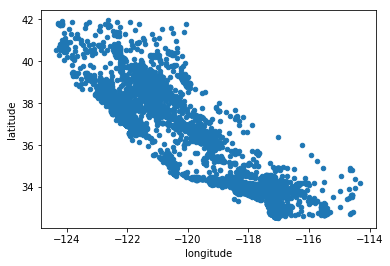

In [23]:
## plot lats and longs
h.plot(kind='scatter', x="longitude", y="latitude");

### Show the density of points by setting alpha parameter

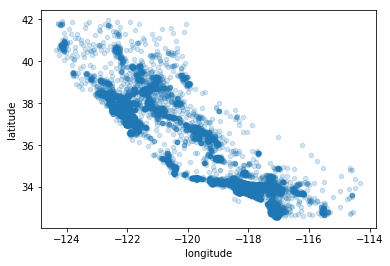

In [24]:
h.plot(kind="scatter", x="longitude", y="latitude", alpha=0.2);

## Show prices
Radius of each circle will represent district's population and the color represents the price. The color map from blue to red will show range of prices

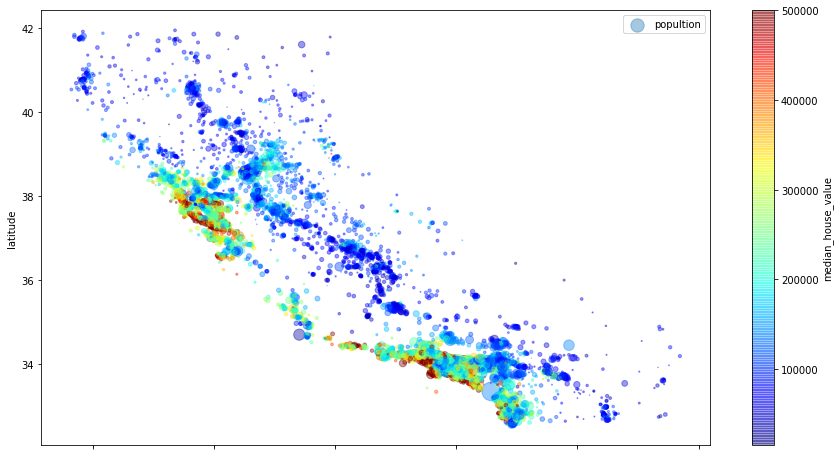

In [25]:
#s option is for the population (size), c option is for the prices and cmap for colormap)
h.plot(kind="scatter",x="longitude", y="latitude", alpha=0.4, s = h['population']/100, 
       label="popultion", c="median_house_value", cmap = plt.get_cmap('jet'), colorbar=True, figsize=(15,8));
plt.legend();

This image tells you that the housing prices are very much related to the location (e.g., close to the ocean) and to the population density, as you probably knew already. It will probably be useful to use a clustering algorithm to detect the main clusters, and add new features that measure the proximity to the cluster centers. The ocean proximity attribute may be useful as well, although in Northern California the housing prices in coastal districts are not too high, so it is not a simple rule.

## Looking for correlation

In [26]:
corr_matrix = h.corr()
#abscorr_matrix2 = housing.corr()

See what is correlated to median_house_value the most (valuse are might differ from book because of shuffling)

In [27]:
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

## Pandas scatter matrix function
plots every numerical attribute against every other numerical attribute: 11^2 121 plots. We'll focus on some of them

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a25a7d518>,
      dtype=object)

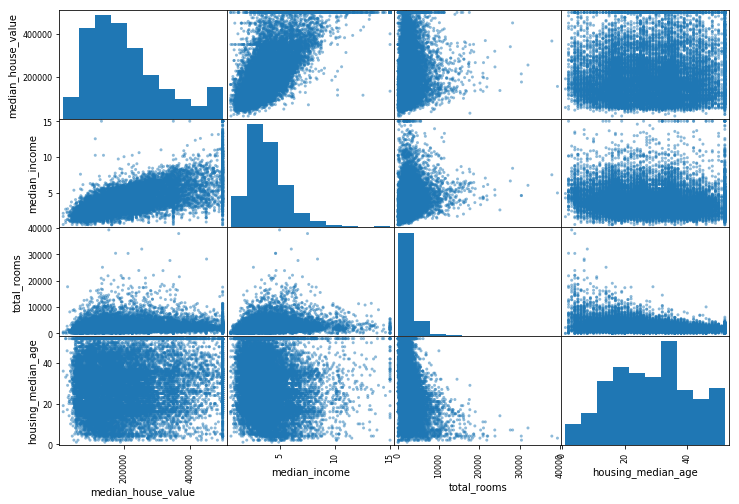

In [28]:
from pandas.plotting import scatter_matrix
attributes = ['median_house_value', "median_income", "total_rooms", "housing_median_age",];
scatter_matrix(h[attributes], figsize=(12,8));

The main diagonal shows a histogram of each attribute, since plotting a variable against itself is not very useful.

# The most significant value for median_house_value seems to be median_income
Let us zoom on its plot

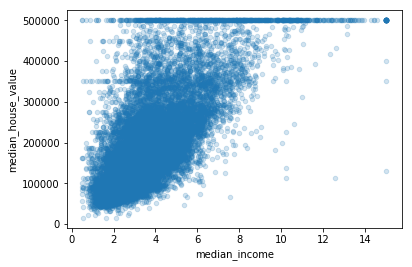

In [29]:
h.plot(kind="scatter", x='median_income', y='median_house_value',alpha=0.2);

### Interpreting scatterplot
It shows that variables are really correlated. We also notice the horizontal line at $\$500,000$ since data prices are capped.

However, there are other horizontal lines at $\$450,000$, at $\$380,000$ and maybe one at $\$280,000$. Maybe it is better to remove these districts so that the algorithm does not learn to reproduce them.

# Data manipulation
The total number of rooms in a district is not very useful if you don’t know how many households there are. What you really want is the number of rooms per household. Similarly, the total number of bedrooms by itself is not very useful: you probably want to compare it to the number of rooms. And the population per household also seems like an interesting attribute combination to look at. Let’s create these new attributes:


In [30]:
h['rooms_per_household']      = h['total_rooms']   /h['households']
h['bedrooms_per_household']   = h['total_bedrooms']/h['total_rooms']
h['population_per_household'] = h['population']    /h['households']

## Let's look at the correlation matrix again

In [31]:
corr_matrix = h.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_household     -0.259984
Name: median_house_value, dtype: float64

#### Interpretation
The new `bedrooms_per_room` attribute is much more correlated with the median house value than the total number of rooms or bedrooms. Apparently houses with a lower bedroom/room ratio tend to be more expensive. The number of rooms per household is also more informative than the total number of rooms in a district—obviously the larger the houses, the more expensive they are.

# Data cleaning
Let's revert to a clean training set and separte target from predictors

In [32]:
# axis=1 tells to drop the column. If not specified, axis=0 and it tries to drop a row with name "median_house_vlaue" 
# but it does not exists and it returns an error.
h = strat_train_set.drop('median_house_value', axis=1)
h_labels = strat_train_set['median_house_value']

In [33]:
type(h)

pandas.core.frame.DataFrame

## missing values
You noticed earlier that the total_bedrooms attribute has some missing values. 3 options:
- `dropna` : get rid of these entries
- `drop`: get rid of the attribute
- `fillna`: set the missing values to some value (0, mean, median)

### Important
If the third option is used, the median must be calculated on the train set and the same value must be saved to be used for missing value in the test set.

### What if values even from different columns will be missing in the test set?

sckit has an `Imputer` class in `sklearn.preprocessing` with a constructor taking one string as `strategy` parameter (for example median). Then we can fit the the imputer to the training and it will calculate the median for all numerical columns. First we have to drop non-numerical columns 

In [34]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='median');
h_num = h.drop('ocean_proximity', axis=1);
imputer.fit(h_num);
imputer.statistics_;

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

In [35]:
h_num.median().values

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

In [36]:
X = imputer.transform(h_num) #output is a numpy array

In [37]:
h_tr = pd.DataFrame(X, columns =h_num.columns)

## Convert text labels to numbers
Many algorithms prefer to work with numbers

In [38]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder();
h_cat = h['ocean_proximity'];
h_cat_encoded = encoder.fit_transform(h_cat);
h_cat_encoded

array([0, 0, 4, ..., 1, 0, 3])

In [39]:
#mapping
print(encoder.classes_)

['<1H OCEAN' 'INLAND' 'ISLAND' 'NEAR BAY' 'NEAR OCEAN']


In [40]:
print(h_cat_encoded) #1D array
print(type(h_cat_encoded))

[0 0 4 ... 1 0 3]
<class 'numpy.ndarray'>


In [41]:
print(h_cat_encoded.reshape(1,16512))
print(h_cat_encoded.reshape(16512,1))

[[0 0 4 ... 1 0 3]]
[[0]
 [0]
 [4]
 ...
 [1]
 [0]
 [3]]


## Problem
One issue with this representation is that ML algorithms will assume that two nearby values are more similar than two distant values. Obviously this is not the case (for example, categories 0 and 4 are more similar than categories 0 and 1). To fix this issue, a common solution is to create one binary attribute for each possible categorical value: one attribute equal to 1 when the category is “<1H OCEAN” (and 0 otherwise), another attribute equal to 1 when the category is “INLAND” (and 0 otherwise), and so on. This is called one-hot encoding, because only one attribute will be equal to 1 (hot), while the others will be 0 (cold).

scikit provides `OneHotEncoder` to convert integer categorical value into one-hot vectors.

In [42]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
#reshape will output a matrix having #rows equal to the first element and columns to the second.
#One shape dimension can be -1. In this case, the value is
#inferred from the length of the array and remaining dimensions. So we'll use -1 instead of 16512
h_cat_1h = encoder.fit_transform(h_cat_encoded.reshape(-1,1)).astype(int)
h_cat_1h.toarray()

/Users/fra/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


array([[1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1],
       ...,
       [0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0]])

Note that the above cell returns a deprecated warning. It must changed to the following:

In [43]:
from sklearn.compose import ColumnTransformer
h_copy = h.copy();
ct = ColumnTransformer([("onehot",OneHotEncoder(),[h_copy.columns.get_loc('ocean_proximity')])]);
onehot = ct.fit_transform(h_copy.values).astype('int').toarray();
onehot

array([[1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1],
       ...,
       [0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0]])

#### Apparently ColumnTransformer has no inverse so we are loosing the references to the category

### We create a dataframe containing the encoding of the categorical variables and then we merge it to the original dataframe

In [44]:
from sklearn.preprocessing import LabelBinarizer
#sparse_output=True compresses the matrix, toarray() to get back
h_copy = h.copy();
enc = LabelBinarizer(sparse_output=True);
onehot = enc.fit_transform(h_copy['ocean_proximity']);
enc.inverse_transform(np.identity(onehot.shape[1])).reshape(-1,);
#ocean_prox_1hotencoded
ocean_prox_df = pd.DataFrame(data=onehot.toarray().astype('int'), 
                columns=enc.inverse_transform(np.identity(onehot.shape[1])));

ocean_prox_df

,<1H OCEAN,INLAND,ISLAND,NEAR BAY,NEAR OCEAN
0,1,0,0,0,0
1,1,0,0,0,0
2,0,0,0,0,1
3,0,1,0,0,0
4,1,0,0,0,0
5,0,1,0,0,0
6,1,0,0,0,0
7,0,1,0,0,0
8,1,0,0,0,0
9,1,0,0,0,0


### Now we concat with the original df



In [45]:
h_cat = pd.concat([h_copy.drop('ocean_proximity', axis=1), ocean_prox_df], axis=1);
h_cat


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,<1H OCEAN,INLAND,ISLAND,NEAR BAY,NEAR OCEAN
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,1.0,0.0,0.0,0.0,0.0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,1.0,0.0,0.0,0.0,0.0
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,0.0,0.0,0.0,0.0,1.0
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,0.0,1.0,0.0,0.0,0.0
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,1.0,0.0,0.0,0.0,0.0
5,-122.25,37.85,52.0,919.0,213.0,413.0,193.0,4.0368,0.0,1.0,0.0,0.0,0.0
6,-122.25,37.84,52.0,2535.0,489.0,1094.0,514.0,3.6591,1.0,0.0,0.0,0.0,0.0
7,-122.25,37.84,52.0,3104.0,687.0,1157.0,647.0,3.1200,0.0,1.0,0.0,0.0,0.0
8,-122.26,37.84,42.0,2555.0,665.0,1206.0,595.0,2.0804,1.0,0.0,0.0,0.0,0.0
9,-122.25,37.84,52.0,3549.0,707.0,1551.0,714.0,3.6912,1.0,0.0,0.0,0.0,0.0


## It is even easier to do it in Pandas

In [46]:
h_copy = h.copy();
ocean_prox_dummies = pd.get_dummies(h_copy.ocean_proximity);
#print(ocean_prox_dummies)
h_res = pd.concat([h_copy, ocean_prox_dummies], axis=1);
h_res.drop('ocean_proximity', axis=1, inplace=True);
print(h_res);

       longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
17606    -121.89     37.29                38.0       1568.0           351.0   
18632    -121.93     37.05                14.0        679.0           108.0   
14650    -117.20     32.77                31.0       1952.0           471.0   
3230     -119.61     36.31                25.0       1847.0           371.0   
3555     -118.59     34.23                17.0       6592.0          1525.0   
19480    -120.97     37.66                24.0       2930.0           588.0   
8879     -118.50     34.04                52.0       2233.0           317.0   
13685    -117.24     34.15                26.0       2041.0           293.0   
4937     -118.26     33.99                47.0       1865.0           465.0   
4861     -118.28     34.02                29.0        515.0           229.0   
16365    -121.31     38.02                24.0       4157.0           951.0   
19684    -121.62     39.14                41.0      

# Custom Transformers
Scikit allows you to create your own transformers using ducking type programming style. In ducking type, an object passed into a function must support all methods and attributes it s expected to have at runtime. The object type itself does not matter. 

For transformers, three methods must be implemented:
- *fit()*
- *transform()*
- *fit_transform*.

We can get the last one for free exploiting inheritance from the base class *TransformerMixin*. By adding also *BaseEstimator* as a base class and avoiding *\*args* and *\*kargs* in constructor, we will get the extra methods *get_params* and *set_params* that will be useful for automatic hyperparameter tuning.

In [47]:
h_copy

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,<1H OCEAN
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,<1H OCEAN
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,NEAR OCEAN
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,INLAND
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,<1H OCEAN
19480,-120.97,37.66,24.0,2930.0,588.0,1448.0,570.0,3.5395,INLAND
8879,-118.50,34.04,52.0,2233.0,317.0,769.0,277.0,8.3839,<1H OCEAN
13685,-117.24,34.15,26.0,2041.0,293.0,936.0,375.0,6.0000,INLAND
4937,-118.26,33.99,47.0,1865.0,465.0,1916.0,438.0,1.8242,<1H OCEAN
4861,-118.28,34.02,29.0,515.0,229.0,2690.0,217.0,0.4999,<1H OCEAN


In [48]:
from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6;

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True):
        self.add_bedrooms_per_room = add_bedrooms_per_room;

    def fit(self, X, y=None):
        return self;
    
    def transform(self, X, y=None):
        rooms_per_household = X[:,rooms_ix]/X[:, household_ix];
        population_per_household = X[:,population_ix]/X[:, household_ix];
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:,bedrooms_ix]/X[:, rooms_ix];
            #np.c_[np.array([1,2,3]), np.array([4,5,6])]
            #array([[1, 4],
            #       [2, 5], 
            #       [3, 6]]) 
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room];
        else:
            return np.c_[X, rooms_per_household, population_per_household];
        
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False);
h_extra_attribs= attr_adder.transform(h_copy.values);
h_extra_attribs

array([[-121.89, 37.29, 38.0, ..., '<1H OCEAN', 4.625368731563422,
        2.094395280235988],
       [-121.93, 37.05, 14.0, ..., '<1H OCEAN', 6.008849557522124,
        2.7079646017699117],
       [-117.2, 32.77, 31.0, ..., 'NEAR OCEAN', 4.225108225108225,
        2.0259740259740258],
       ...,
       [-116.4, 34.09, 9.0, ..., 'INLAND', 6.34640522875817,
        2.742483660130719],
       [-118.01, 33.82, 31.0, ..., '<1H OCEAN', 5.50561797752809,
        3.808988764044944],
       [-122.45, 37.77, 52.0, ..., 'NEAR BAY', 4.843505477308295,
        1.9859154929577465]], dtype=object)

In [49]:
h_copy.head()
#h.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,<1H OCEAN
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,<1H OCEAN
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,NEAR OCEAN
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,INLAND
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,<1H OCEAN


# Feature Scaling
Different procedures:
- **min-max** or **normalization**: values are scaled to be in range [0,1]. Minimum value is subtracted and then it is scaled by the max value. Scikit provides MinMaxScaler with *feature_range* property to change the range.
- **standardization**: it subtracts the mean value (0-mean) and then divides by the variance to have a unit variance distribution. Standardization is much less affected by outliers but might be a problem for some algorithms (such as NN) expecting values to be within a given range.

# Transformation Pipelines
All but last estimator must be transformers i.e. they must have the method *fit_transform*.
When you call the pipeline’s *fit()* method, it calls *fit_transform()* sequentially on all transformers, passing the output of each call as the parameter to the next call, until it reaches the final estimator, for which it just calls the *fit()* method and then *transform()*.

In [50]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
num_pipeline = Pipeline([('imputer', SimpleImputer(strategy='median')),
                        ('attribs_adder', CombinedAttributesAdder()),
                         ('std_scaler', StandardScaler())
                        ]);
h_num_tr = num_pipeline.fit_transform(h.drop('ocean_proximity',axis=1));
h_num_tr

array([[-1.15604281,  0.77194962,  0.74333089, ..., -0.31205452,
        -0.08649871,  0.15531753],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.21768338,
        -0.03353391, -0.83628902],
       [ 1.18684903, -1.34218285,  0.18664186, ..., -0.46531516,
        -0.09240499,  0.4222004 ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.3469342 ,
        -0.03055414, -0.52177644],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.02499488,
         0.06150916, -0.30340741],
       [-1.43579109,  0.99645926,  1.85670895, ..., -0.22852947,
        -0.09586294,  0.10180567]])

## Merge with categorical values
The scaling of numerical values and the transformation of categorical values to many binary attributes are independent, hence they can be performed in parallel.

Scikit provides ***FeatureUnion*** class. You give it a list of transformers (which can be entire transformer pipelines), and when its ***transform()*** method is called, it runs each transformer’s ***transform()*** method in parallel, waits for their output, and then concatenates them and returns the result (and of course calling its ***fit()*** method calls all each transformer’s ***fit()*** method). A full pipeline handling both numerical and categorical attributes may look like this:

### Managing df
Each subpipeline starts with a selector transformer: it simply transforms the data by selecting the desired attributes (numerical or categorical), dropping the rest, and con‐ verting the resulting DataFrame to a NumPy array. There is nothing in Scikit-Learn to handle Pandas DataFrames,20 so we need to write a simple custom transformer for this task:

There is nothing in Scikit-Learn to handle Pandas DataFrames, so we need to write a simple custom transformer for this task:

In [51]:
from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names;
    def fit(self, X, y=None):
        return self;
    def transform(self, X):
        return X[self.attribute_names].values
        
    

## Out of the book:
In the following script a new class, ***LabelBinarizerPipelineFriendly***, had to be craated. This because the method ***fit_transform*** changed from version 0.18 to 0.19. The problem is that now it accepts just two input: the instance and the array to be encoded: 

    lb.fit_transform(['yes', 'no', 'no', 'yes'])
    
We overload ***fit_transform*** method to accept another parameter *y* that actually it is not used. by first calling *fit* and then *transform*

In [52]:
class LabelBinarizerPipelineFriendly(LabelBinarizer):
     def fit(self, X, y=None):
         """this would allow us to fit the model based on the X input."""
         super(LabelBinarizerPipelineFriendly, self).fit(X)
     def transform(self, X, y=None):
         return super(LabelBinarizerPipelineFriendly, self).transform(X)

     def fit_transform(self, X, y=None):
         return super(LabelBinarizerPipelineFriendly, self).fit(X).transform(X)


from sklearn.pipeline import FeatureUnion;
num_attr = list(h.drop('ocean_proximity',axis=1))
cat_attr = ['ocean_proximity']
num_pipeline = Pipeline([
                        ('selector', DataFrameSelector(num_attr)),
                        ('imputer', SimpleImputer(strategy='median')),
                        ('attribs_adder', CombinedAttributesAdder()),
                        ('std_scaler', StandardScaler())
                        ]);
cat_pipeline = Pipeline([
                        ('selector'       , DataFrameSelector(cat_attr)),
                        ('label_binarizer', LabelBinarizerPipelineFriendly())#using custom because fit_transform method changed
                        ]);
full_pipeline = FeatureUnion(
            transformer_list =[
                              ("num_pipeline", num_pipeline), 
                              ("cat_pipeline", cat_pipeline)
                              ]);
h_prepared = full_pipeline.fit_transform(h);

# Train a model
## Linear Regression

In [53]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(h_prepared, h_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

### Linear Regression results

In [54]:
some_data = h.iloc[:5];
some_labels = h_labels.iloc[:5];
some_data_prep = full_pipeline.transform(some_data);
print("predictions: ", lin_reg.predict(some_data_prep));
print("labels: ", list(some_labels));

predictions:  [210644.60459286 317768.80697211 210956.43331178  59218.98886849
 189747.55849879]
labels:  [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


#### It works but it is not good

In [55]:
from sklearn.metrics import mean_squared_error
h_pred_train = lin_reg.predict(h_prepared);
lin_rmse = np.sqrt(mean_squared_error(h_labels, h_pred_train));
lin_rmse

68628.19819848923

#### The error is too much
most districts' median_housing_values range between $120,000$ and $265,000$, so a typical predic‐ tion error of $68,628 is not very satisfying.

### Underfitting
The features do not provide enough information or the model is not powerful enough.
Solutions are:
- select a more powerful model
- feed the training problem with better features
- reduce constraints on the model (the model is not regularized)


## Decision Tree Regressor
It finds complex non-linear relationships in the data.

In [56]:
from sklearn.tree import DecisionTreeRegressor
tree_reg = DecisionTreeRegressor()
tree_reg.fit(h_prepared, h_labels)
h_tree_pred = tree_reg.predict(h_prepared)
tree_rmse = np.sqrt(mean_squared_error(h_labels, h_tree_pred))
tree_rmse

0.0

You don’t want to touch the test set until you are ready to launch a model you are confident about, so you need to use part of the training set for train‐ ing, and part for model validation.

# Cross-validation
One way to evaluate the model is to split the training set into a smaller training set and a validation set, then train your models against the smaller training set and evaluate them against the validation set. It’s a bit of work, but nothing too difficult and it would work fairly well.

An alternative is to use *cross-validation* feature. The following code performs *k-fold cross-validation*: it randomly splits the set into 10 distinct subsets called folds: it randomly splits the training set into 10 distinct subsets called folds, then it trains and evaluates the Decision Tree model 10 times, picking a different fold for evaluation every time and training on the other 9 folds. The result is an array containing the 10 evaluation scored.

But cross-validation comes at the cost of training the model several times, so it is not always possible.

In [57]:
from sklearn.model_selection import cross_val_score
tree_reg = DecisionTreeRegressor()
scores = cross_val_score(tree_reg, h_prepared, h_labels, scoring="neg_mean_squared_error", cv=10);
rmse_scores = np.sqrt(-scores);

def displayScores(scores):
    print("Scores", scores);
    print("Mean", scores.mean());
    print("Standard deviation", scores.std());
displayScores(rmse_scores)

Scores [68422.98271486 67728.34663791 71419.66795531 70365.93923396
 70857.18243772 74983.50462605 71911.7323366  71673.88486202
 78123.12509924 69084.15877918]
Mean 71457.0524682847
Standard deviation 2956.6426881709704


## Random Forests

In [58]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor();
forest_reg.fit(h_prepared, h_labels);
h_forest_pred = forest_reg.predict(h_prepared);
forest_rmse = np.sqrt(mean_squared_error(h_labels, h_forest_pred));
print("error on training:\t",forest_rmse);
forest_reg = RandomForestRegressor(n_estimators=100000, to);
forests_scores = cross_val_score(forest_reg, h_prepared, h_labels, 
                                 scoring="neg_mean_squared_error", cv=10);
rmse_forest_scores = np.sqrt(-forests_scores);
displayScores(rmse_forest_scores)

/Users/fra/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


error on training:	 22405.082140602353


/Users/fra/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/fra/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/fra/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/fra/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/fra/anaconda3/lib/python3.7/site-packages/skl

Scores [52325.05555397 49734.03444572 51180.70204472 55049.50059802
 52302.30374085 56572.4399816  51351.54112682 49454.61373527
 55938.2834947  54253.85217585]
Mean 52816.23268975229
Standard deviation 2388.2340254713313


### Comments on Random forests result
Much better but it is still overfitting: error on training is much lower than the error on test.

# Grid search
The sklearn function *GridSearchCV*, search for the best combination of specified hyperparameters using Cross-Validation

In [92]:
from sklearn.model_selection import GridSearchCV
param_grid = [{"n_estimators":[3,10,30], "max_features":[2,4,6,8]},
             {"bootstrap":[False],"n_estimators":[3,10], "max_features":[2,3,4,]}]
forest_reg = RandomForestRegressor()
rf_grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring="neg_mean_squared_error")
rf_grid_search.fit(h_prepared, h_labels)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]}, {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [60]:
forest_reg.get_params().keys()

dict_keys(['bootstrap', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

In [61]:
rf_grid_search.best_params_

{'max_features': 6, 'n_estimators': 30}

In [62]:
rf_grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=6, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=30, n_jobs=None, oob_score=False,
           random_state=None, verbose=0, warm_start=False)

If GridSearchCV is initialized with `refit=True` (which is the default), then once it finds the best estimator using cross-validation, it retrains it on the whole training set.

In [63]:
cvres = rf_grid_search.cv_results_
for mean, p in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean), p)

63740.08421033131 {'max_features': 2, 'n_estimators': 3}
55688.91620065839 {'max_features': 2, 'n_estimators': 10}
52861.97657444578 {'max_features': 2, 'n_estimators': 30}
61379.3526797869 {'max_features': 4, 'n_estimators': 3}
53041.27390242521 {'max_features': 4, 'n_estimators': 10}
50695.68369246598 {'max_features': 4, 'n_estimators': 30}
60068.30892024859 {'max_features': 6, 'n_estimators': 3}
52031.904788709086 {'max_features': 6, 'n_estimators': 10}
49968.86315354842 {'max_features': 6, 'n_estimators': 30}
57753.40460850653 {'max_features': 8, 'n_estimators': 3}
51964.10055638212 {'max_features': 8, 'n_estimators': 10}
50191.679569093 {'max_features': 8, 'n_estimators': 30}
61643.98265090648 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54178.137307728335 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
59888.32975169027 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52423.393624660064 {'bootstrap': False, 'max_features': 3, 'n_estimators': 10

# Analyzing the best model
By inspecting the best model it is possible to find many useful clues, for example the importance of each attribute for making accurate predictions

In [64]:
feature_importances = rf_grid_search.best_estimator_.feature_importances_;

In [65]:
feature_importances

array([8.18248930e-02, 7.00134947e-02, 4.30692429e-02, 1.77020665e-02,
       1.67814398e-02, 1.65358341e-02, 1.59153915e-02, 3.28769105e-01,
       5.83652386e-02, 1.04307250e-01, 7.42271887e-02, 1.14623228e-02,
       1.46828179e-01, 6.61021980e-05, 7.40816416e-03, 6.72408659e-03])

In [66]:
extra_attribs = ["rooms_per_hhold", "pop_per_hhold","bedrooms_per_room"];
cat_one_hot_attribs = list(ocean_prox_dummies.columns.values);
num_attribs = list(h_num.columns.values)
attributes  = num_attribs + extra_attribs + cat_one_hot_attribs;
attributes

['longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income',
 'rooms_per_hhold',
 'pop_per_hhold',
 'bedrooms_per_room',
 '<1H OCEAN',
 'INLAND',
 'ISLAND',
 'NEAR BAY',
 'NEAR OCEAN']

In [67]:
sorted(zip(feature_importances, attributes), reverse=True)

[(0.3287691052204217, 'median_income'),
 (0.14682817904221787, 'INLAND'),
 (0.10430725011832623, 'pop_per_hhold'),
 (0.08182489301483531, 'longitude'),
 (0.07422718871098663, 'bedrooms_per_room'),
 (0.07001349468723965, 'latitude'),
 (0.0583652386397237, 'rooms_per_hhold'),
 (0.04306924290005181, 'housing_median_age'),
 (0.01770206653046337, 'total_rooms'),
 (0.01678143977400127, 'total_bedrooms'),
 (0.0165358341286108, 'population'),
 (0.01591539149714461, 'households'),
 (0.011462322784506922, '<1H OCEAN'),
 (0.007408164159766135, 'NEAR BAY'),
 (0.006724086593721112, 'NEAR OCEAN'),
 (6.610219798288371e-05, 'ISLAND')]

#### Apparantly only IN_LAND among ocean_proximity categories is important: maybe we can drop the others.

In [68]:
type(ocean_prox_dummies.columns.values)

numpy.ndarray

# Test evaluation

In [69]:
final_model = rf_grid_search.best_estimator_

h_test = strat_test_set.drop("median_house_value", axis=1)
h_label_test = strat_test_set["median_house_value"].copy()

h_test_prep = full_pipeline.transform(h_test)
final_predictions = final_model.predict(h_test_prep)
final_rmse = np.sqrt(mean_squared_error(h_label_test, final_predictions))
final_rmse

47639.34546067754

In [70]:
strat_test_set.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity'],
      dtype='object')

The performance will usually be slightly worse than what you measured using cross- validation if you did a lot of hyperparameter tuning (because your system ends up fine-tuned to perform well on the validation data, and will likely not perform as well on unknown datasets). It is not the case in this example, but when this happens you must resist the temptation to tweak the hyperparameters to make the numbers look good on the test set; the improvements would be unlikely to generalize to new data.

## SVM


In [71]:
from sklearn.svm import SVR

svm = SVR()
param_grid = [{"kernel": ["linear"], "C":[1,10,30]},
              {"kernel": ["rbf"], "C":[1,10,30,], "gamma":[0.1,1,10]}]
svm_grid_search = GridSearchCV(svm, param_grid, cv=5, scoring="neg_mean_squared_error")


In [72]:
svm_grid_search.fit(h_prepared, h_labels)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'kernel': ['linear'], 'C': [1, 10, 30]}, {'kernel': ['rbf'], 'C': [1, 10, 30], 'gamma': [0.1, 1, 10]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [73]:
cvres = svm_grid_search.cv_results_
for mean, p in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean), p)

112571.79521013204 {'C': 1, 'kernel': 'linear'}
84654.0893002138 {'C': 10, 'kernel': 'linear'}
75448.84743960595 {'C': 30, 'kernel': 'linear'}
118637.95452846108 {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}
118886.40095734302 {'C': 1, 'gamma': 1, 'kernel': 'rbf'}
118922.40012286499 {'C': 1, 'gamma': 10, 'kernel': 'rbf'}
116179.73058899572 {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
118595.3378452412 {'C': 10, 'gamma': 1, 'kernel': 'rbf'}
118917.31428059156 {'C': 10, 'gamma': 10, 'kernel': 'rbf'}
111155.97324467346 {'C': 30, 'gamma': 0.1, 'kernel': 'rbf'}
117945.46989557479 {'C': 30, 'gamma': 1, 'kernel': 'rbf'}
118914.60851572135 {'C': 30, 'gamma': 10, 'kernel': 'rbf'}


In [74]:
grid_search.best_params_

{'C': 30, 'kernel': 'linear'}

In [75]:
svm_grid_search.best_estimator_

SVR(C=30, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma='auto_deprecated', kernel='linear', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False)

## Randomized search

The grid search approach is fine when you are exploring relatively few combinations, like in the previous example, but when the hyperparameter search space is large, it is often preferable to use RandomizedSearchCV instead. This class can be used in much the same way as the GridSearchCV class, but instead of trying out all possible combinations, it evaluates a given number of random combinations by selecting a random value for each hyperparameter at every iteration. This approach has two main benefits:

- it will explore as many combinations as the number of iterations you let it run
- you have more control in terms of HW resources by setting the number of iterations

Suppose you give a total of 12 models (4 values for one parameter and 3 values for another). It will test only `n_iter` models. By default this parameter is set to 10. In case the number of models is less than `n_iter`, a warning is generated.

In [76]:
from sklearn.model_selection import RandomizedSearchCV
param_grid = {"kernel": ["linear", "rbf"],"C":[1,10,30], "gamma":[0.1,1,10], }
random_search = RandomizedSearchCV(svm, param_grid, cv=5, scoring="neg_mean_squared_error")

In [77]:
svm.get_params().keys()

dict_keys(['C', 'cache_size', 'coef0', 'degree', 'epsilon', 'gamma', 'kernel', 'max_iter', 'shrinking', 'tol', 'verbose'])

In [78]:
random_search.fit(h_prepared, h_labels)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False),
          fit_params=None, iid='warn', n_iter=10, n_jobs=None,
          param_distributions={'kernel': ['linear', 'rbf'], 'C': [1, 10, 30], 'gamma': [0.1, 1, 10]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='neg_mean_squared_error',
          verbose=0)

In [79]:
svm

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False)

In [86]:
cvres = random_search.cv_results_
for mean, p in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean), p)

112571.79521013204 {'kernel': 'linear', 'gamma': 1, 'C': 1}
118917.31428059156 {'kernel': 'rbf', 'gamma': 10, 'C': 10}
75448.84743960595 {'kernel': 'linear', 'gamma': 0.1, 'C': 30}
118637.95452846108 {'kernel': 'rbf', 'gamma': 0.1, 'C': 1}
118595.3378452412 {'kernel': 'rbf', 'gamma': 1, 'C': 10}
84654.0893002138 {'kernel': 'linear', 'gamma': 10, 'C': 10}
118922.40012286499 {'kernel': 'rbf', 'gamma': 10, 'C': 1}
117945.46989557479 {'kernel': 'rbf', 'gamma': 1, 'C': 30}
84654.0893002138 {'kernel': 'linear', 'gamma': 0.1, 'C': 10}
118886.40095734302 {'kernel': 'rbf', 'gamma': 1, 'C': 1}


In [87]:
random_search.best_params_

{'kernel': 'linear', 'gamma': 0.1, 'C': 30}

In [88]:
random_search.best_estimator_

SVR(C=30, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.1,
  kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [90]:
random_search.best_estimator_

SVR(C=30, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.1,
  kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [100]:
from sklearn.feature_selection import RFE
'''[(0.3287691052204217, 'median_income'),
 (0.14682817904221787, 'INLAND'),
 (0.10430725011832623, 'pop_per_hhold'),
 (0.08182489301483531, 'longitude'),
 (0.07422718871098663, 'bedrooms_per_room'),
 (0.07001349468723965, 'latitude'),
 (0.0583652386397237, 'rooms_per_hhold'),
 (0.04306924290005181, 'housing_median_age'),
 (0.01770206653046337, 'total_rooms'),
 (0.01678143977400127, 'total_bedrooms'),
 (0.0165358341286108, 'population'),
 (0.01591539149714461, 'households'),
 (0.011462322784506922, '<1H OCEAN'),
 (0.007408164159766135, 'NEAR BAY'),
 (0.006724086593721112, 'NEAR OCEAN'),
 (6.610219798288371e-05, 'ISLAND')]'''
class PipelineRFE(Pipeline):

    def fit(self, X, y=None, **fit_params):
        super(PipelineRFE, self).fit(X, y, **fit_params)
        self.feature_importances_ = self.steps[-1][-1].feature_importances_
        return self

rfe_pipeline = PipelineRFE(full_pipeline);
feature_selector_cv = feature_selection.RFE(rfe_pipeline, scoring="neg_mean_squared_error")

TypeError: type object argument after * must be an iterable, not FeatureUnion

In [97]:
significant_featueres = [el for v,el in sorted(zip(feature_importances, attributes), reverse=True) if v>0.04]

In [98]:
significant_featueres

['median_income',
 'INLAND',
 'pop_per_hhold',
 'longitude',
 'bedrooms_per_room',
 'latitude',
 'rooms_per_hhold',
 'housing_median_age']